### Definition of Rogue Device
A **rogue device** refers to any unauthorized or suspicious device that connects to a critical infrastructure network. These devices often pose security threats, such as:
- Unauthorized access to sensitive systems.
- Network disruptions caused by repeated DHCP discovery or misconfigurations.
- Devices attempting to perform malicious activities, like denial of service (DoS) attacks or data exfiltration.

In **DHCP logs**, rogue devices can exhibit the following behaviors:
1. **Repeated DISCOVER Messages**: Flooding the network with DHCP requests.
2. **Missing IP Assignment**: Devices that don't receive an `assigned_addr` due to invalid requests or misconfigurations.
3. **Unknown MAC Addresses**: Devices with unrecognized MAC addresses.
4. **Abnormal Lease Times**: Lease times that are unusually short or long.

---

### Code Overview
This code focuses on detecting rogue devices in **DHCP logs** using a machine learning-based anomaly detection technique, specifically **Isolation Forest**. Here's the step-by-step explanation:

---

### Step 1: Loading DHCP Logs
```python
def load_dhcp_logs(file_path):
    """Load DHCP logs and return as a DataFrame."""
    with gzip.open(file_path, 'rb') as gzipped_file:
        with tempfile.NamedTemporaryFile(mode='wb', delete=False) as temp_file:
            temp_file.write(gzipped_file.read())
            uncompressed_path = temp_file.name

    log_to_df = LogToDataFrame()
    df = log_to_df.create_dataframe(uncompressed_path).reset_index()
    print("DHCP DataFrame loaded successfully!")
    return df
```
- Reads a **DHCP log file** (`.log.gz`) and parses it into a Pandas DataFrame using the `zat` library.
- Uses a temporary uncompressed file to enable processing.

---

### Step 2: Preprocessing the Data
```python
def preprocess_dhcp_data(df):
    """Preprocess DHCP logs for ML."""
    # Replace missing values with placeholders for categorical columns
    for col in ['client_addr', 'host_name', 'assigned_addr']:
        if pd.api.types.is_categorical_dtype(df[col]):
            df[col] = df[col].cat.add_categories("UNKNOWN")
        df[col] = df[col].fillna("UNKNOWN")
    
    # Encode categorical columns (mac, host_name, msg_types)
    label_encoder = LabelEncoder()
    df['mac_encoded'] = label_encoder.fit_transform(df['mac'])
    df['host_name_encoded'] = label_encoder.fit_transform(df['host_name'])
    df['msg_types_encoded'] = label_encoder.fit_transform(df['msg_types'])
    
    # Convert duration to seconds and replace NaT with 0
    df['duration_sec'] = df['duration'].dt.total_seconds().fillna(0)

    # Select features for ML
    features = df[['mac_encoded', 'host_name_encoded', 'msg_types_encoded', 'duration_sec']]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    return scaled_features, df
```
#### Key Steps:
1. **Handling Missing Values**:
   - For categorical columns (`client_addr`, `host_name`, `assigned_addr`), missing values are replaced with `"UNKNOWN"`.
2. **Encoding Categorical Columns**:
   - Columns like `mac`, `host_name`, and `msg_types` are encoded into numerical values using `LabelEncoder`.
3. **Duration Conversion**:
   - `duration` is converted to seconds for numeric analysis.
4. **Feature Scaling**:
   - Features are standardized using `StandardScaler` to ensure they are on the same scale.

---

### Step 3: Detecting Rogue Devices
```python
def detect_rogue_devices(features, contamination=0.01):
    """Apply Isolation Forest to detect rogue devices."""
    iso_forest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    predictions = iso_forest.fit_predict(features)
    return predictions
```
#### Explanation:
- **Isolation Forest**:
   - A machine learning algorithm for unsupervised anomaly detection.
   - It isolates anomalies by recursively partitioning the feature space.
   - `contamination` specifies the proportion of anomalies expected (e.g., 1% anomalies).
- **Input**:
   - Standardized features from preprocessing.
- **Output**:
   - Predictions: `-1` indicates an anomaly (rogue device), and `1` indicates a normal device.

---

### Step 4: Visualizing Rogue Devices
```python
def visualize_rogue_devices(df, predictions):
    """Visualize detected rogue devices."""
    df['anomaly'] = predictions
    df['anomaly_label'] = df['anomaly'].map({1: "Normal", -1: "Rogue"})
    
    # Count anomalies by MAC address
    anomaly_counts = df[df['anomaly'] == -1]['mac'].value_counts()
    print("\nTop Rogue Devices by MAC Address:")
    print(anomaly_counts.head())

    # Visualization: Count of Rogue vs Normal Devices
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='anomaly_label', palette="Set2")
    plt.title("Count of Rogue vs Normal Devices")
    plt.xlabel("Device Status")
    plt.ylabel("Count")
    plt.show()
    
    # Scatter plot for MAC Encoded vs Duration
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='mac_encoded', y='duration_sec', hue='anomaly_label', data=df, palette='Set1')
    plt.title("Anomaly Detection: MAC Encoded vs Duration")
    plt.xlabel("MAC Encoded")
    plt.ylabel("Duration (seconds)")
    plt.legend()
    plt.show()
```
#### Key Visualizations:
1. **Bar Chart**:
   - Count of `Rogue` vs `Normal` devices.
2. **Scatter Plot**:
   - `mac_encoded` vs `duration_sec` to visualize how anomalies differ from normal devices.

---

### Step 5: Main Pipeline Execution
```python
def main():
    file_path = "../zeek/logs/2024-12-16/dhcp.10:07:28-11:00:00.log.gz"

    # Step 1: Load Logs
    df_dhcp = load_dhcp_logs(file_path)
    
    # Step 2: Preprocess Logs
    features, df_cleaned = preprocess_dhcp_data(df_dhcp)
    
    # Step 3: Detect Rogue Devices
    predictions = detect_rogue_devices(features, contamination=0.01)
    
    # Step 4: Visualize Results
    visualize_rogue_devices(df_cleaned, predictions)
    
    # Display rogue devices
    rogue_devices = df_cleaned[df_cleaned['anomaly'] == -1]
    print("\nDetected Rogue Devices:")
    print(rogue_devices[['ts', 'mac', 'host_name', 'msg_types', 'duration']].head())

if __name__ == "__main__":
    main()
```

---

### Sample Output:
1. **Top Rogue Devices**:
   ```
   Top Rogue Devices by MAC Address:
   aa:b3:b9:a4:de:d1    50
   78:9a:18:73:92:f0    35
   ```

2. **Visualizations**:
   - **Bar Chart**: Shows `Rogue` and `Normal` device counts.
   - **Scatter Plot**: Highlights anomalies based on MAC and duration.

3. **Detected Rogue Devices**:
   ```
   Detected Rogue Devices:
                            ts             mac    host_name  msg_types      duration
   2024-12-16 10:07:17.393  aa:b3:b9:a4:de:d1    MikroTik     DISCOVER     0 days
   2024-12-16 10:07:17.393  78:9a:18:73:92:f0    MikroTik     DISCOVER     0 days
   ```

---

### Key Takeaways:
- **Isolation Forest** is effective for detecting rogue devices in DHCP logs.
- Preprocessing ensures categorical and numeric features are ML-ready.
- Visualizations help identify patterns and verify anomalies.


In [14]:
# pip install zat pandas scikit-learn matplotlib seaborn

Loading dhcp Logs...
Loading ../zeek/logs/2024-12-16/dhcp.10:07:28-11:00:00.log.gz...
Loading ../zeek/logs/2024-12-16/dhcp.11:00:00-06:50:48.log.gz...


/tmp/ipykernel_137185/1291003651.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[col]):



Top Rogue Devices by MAC Address:
mac
bc:a8:a6:69:10:ef    3
b6:15:c6:30:85:2e    3
02:20:a4:51:f4:38    2
be:6d:4b:02:c0:d9    1
a0:d0:5b:cf:02:60    1
Name: count, dtype: int64


/tmp/ipykernel_137185/1291003651.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='anomaly_label', palette="Set2")


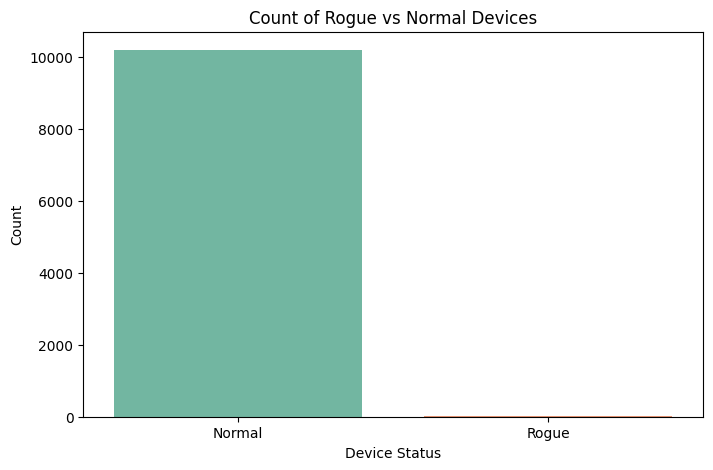

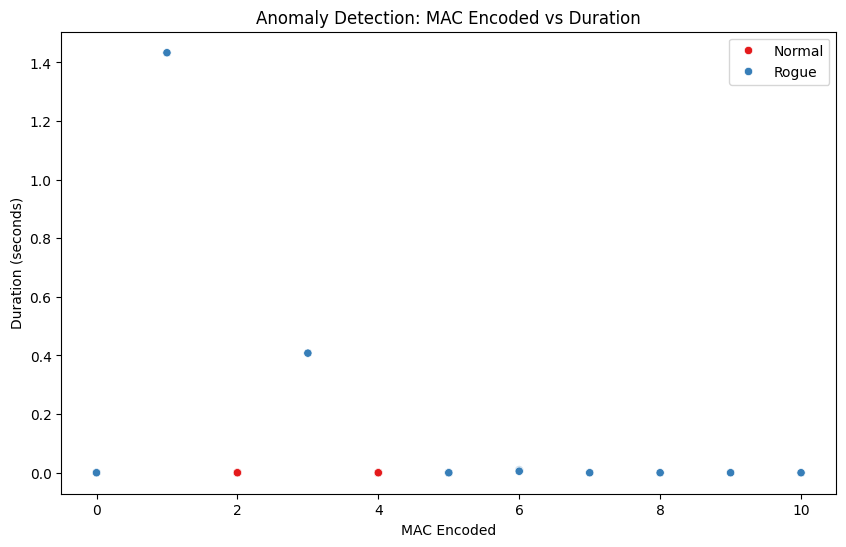


Detected Rogue Devices:
                                ts                mac   host_name  \
5    2024-12-16 10:07:13.011220932  bc:a8:a6:69:10:ef      vision   
1051 2024-12-16 10:16:12.251039982  a0:d0:5b:cf:02:60     Samsung   
2161 2024-12-16 10:25:37.623789072  be:6d:4b:02:c0:d9  MacBookAir   
3494 2024-12-16 10:37:12.194256067  b6:15:c6:30:85:2e     UNKNOWN   
3501 2024-12-16 10:37:13.011147022  bc:a8:a6:69:10:ef      vision   

                      msg_types               duration  
5                   REQUEST,ACK 0 days 00:00:00.009200  
1051  DISCOVER,DISCOVER,REQUEST 0 days 00:00:00.408007  
2161                    REQUEST        0 days 00:00:00  
3494                    REQUEST        0 days 00:00:00  
3501                REQUEST,ACK 0 days 00:00:00.007232  


In [18]:
import gzip
import tempfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zat.log_to_dataframe import LogToDataFrame
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Step 1: Load and Read DHCP Logs
def load_logs(log_directory, log_type="conn"):
    """Load DNS log files from a directory."""
    log_to_df = LogToDataFrame()
    dfs = []
    for file in sorted(os.listdir(log_directory)):
        if log_type in file and file.endswith(".gz"):
            file_path = os.path.join(log_directory, file)
            print(f"Loading {file_path}...")
            with gzip.open(file_path, "rb") as gzipped_file:
                with tempfile.NamedTemporaryFile(mode="wb", delete=False) as temp_file:
                    temp_file.write(gzipped_file.read())
                    uncompressed_path = temp_file.name
            df = log_to_df.create_dataframe(uncompressed_path).reset_index()
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Step 2: Preprocess the DHCP Log Data
def preprocess_dhcp_data(df):
    """Preprocess DHCP logs for ML."""
    # Replace missing values with placeholders for categorical columns
    for col in ['client_addr', 'host_name', 'assigned_addr']:
        if pd.api.types.is_categorical_dtype(df[col]):
            # Add "UNKNOWN" to categories before replacing
            df[col] = df[col].cat.add_categories("UNKNOWN")
        df[col] = df[col].fillna("UNKNOWN")
    
    # Encode categorical columns (mac, host_name, msg_types)
    label_encoder = LabelEncoder()
    df['mac_encoded'] = label_encoder.fit_transform(df['mac'])
    df['host_name_encoded'] = label_encoder.fit_transform(df['host_name'])
    df['msg_types_encoded'] = label_encoder.fit_transform(df['msg_types'])
    
    # Convert duration to seconds and replace NaT with 0
    df['duration_sec'] = df['duration'].dt.total_seconds().fillna(0)

    # Select features for ML
    features = df[['mac_encoded', 'host_name_encoded', 'msg_types_encoded', 'duration_sec']]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    return scaled_features, df


# Step 3: Detect Rogue Devices using Isolation Forest
def detect_rogue_devices(features, contamination=0.01):
    """Apply Isolation Forest to detect rogue devices."""
    iso_forest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    predictions = iso_forest.fit_predict(features)
    return predictions

# Step 4: Visualize Rogue Devices
def visualize_rogue_devices(df, predictions):
    """Visualize detected rogue devices."""
    df['anomaly'] = predictions
    df['anomaly_label'] = df['anomaly'].map({1: "Normal", -1: "Rogue"})
    
    # Count anomalies by MAC address
    anomaly_counts = df[df['anomaly'] == -1]['mac'].value_counts()
    print("\nTop Rogue Devices by MAC Address:")
    print(anomaly_counts.head())

    # Visualization: Count of Rogue vs Normal Devices
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='anomaly_label', palette="Set2")
    plt.title("Count of Rogue vs Normal Devices")
    plt.xlabel("Device Status")
    plt.ylabel("Count")
    plt.show()
    
    # Scatter plot for MAC Encoded vs Duration
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='mac_encoded', y='duration_sec', hue='anomaly_label', data=df, palette='Set1')
    plt.title("Anomaly Detection: MAC Encoded vs Duration")
    plt.xlabel("MAC Encoded")
    plt.ylabel("Duration (seconds)")
    plt.legend()
    plt.show()

# Main Function
def main():
    log_directory = "../zeek/logs/2024-12-16"
    log_type='dhcp'
    print(f"Loading {log_type} Logs...")
    df_dhcp = load_logs(log_directory,log_type)

    # Step 1: Load Logs
    # df_dhcp = load_dhcp_logs(file_path)
    
    # Step 2: Preprocess Logs
    features, df_cleaned = preprocess_dhcp_data(df_dhcp)
    
    # Step 3: Detect Rogue Devices
    predictions = detect_rogue_devices(features, contamination=0.01)
    
    # Step 4: Visualize Results
    visualize_rogue_devices(df_cleaned, predictions)
    
    # Display rogue devices
    rogue_devices = df_cleaned[df_cleaned['anomaly'] == -1]
    print("\nDetected Rogue Devices:")
    print(rogue_devices[['ts', 'mac', 'host_name', 'msg_types', 'duration']].head())

if __name__ == "__main__":
    main()
